<a href="https://www.kaggle.com/code/kirillgubkin/author-classification-nlp?scriptVersionId=289871129" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/author-classification/(Strugatsky)_test.txt
/kaggle/input/author-classification/(Bulgakov)_train.txt
/kaggle/input/author-classification/(Max_Frei)_train.txt
/kaggle/input/author-classification/(Bradbury)_train.txt
/kaggle/input/author-classification/(O.Henry)_test.txt
/kaggle/input/author-classification/(O.Henry)_train.txt
/kaggle/input/author-classification/(Bulgakov)_test.txt
/kaggle/input/author-classification/(Max_Frei)_test.txt
/kaggle/input/author-classification/(Clifford)_train.txt
/kaggle/input/author-classification/(Clifford)_test.txt
/kaggle/input/author-classification/(Strugatsky)_train.txt
/kaggle/input/author-classification/(Bradbury)_test.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

2026-01-03 17:30:44.773169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767461444.999146      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767461445.071416      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767461445.626380      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767461445.626421      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767461445.626424      24 computation_placer.cc:177] computation placer alr

In [3]:
def readText(filename):
    f = open(filename, 'r')
    text = f.read()
    text = text.replace('\n', ' ')
    return text

className = ['O.Henry', 'Strugatsky', 'Bulgakov', 'Clifford', 'Max_Frei', 'Bradbury']
nClasses = len(className)

In [4]:
trainText = []
testText = []

for i in className:
    for j in os.listdir('/kaggle/input/author-classification/'):
        if i in j:
            if 'train' in j:
                trainText.append(readText('/kaggle/input/author-classification/' + j))
                print(j, 'add trainText')
            if 'test' in j:
                testText.append(readText('/kaggle/input/author-classification/' + j))
                print(j, 'add testText')
    print()

(O.Henry)_test.txt add testText
(O.Henry)_train.txt add trainText

(Strugatsky)_test.txt add testText
(Strugatsky)_train.txt add trainText

(Bulgakov)_train.txt add trainText
(Bulgakov)_test.txt add testText

(Clifford)_train.txt add trainText
(Clifford)_test.txt add testText

(Max_Frei)_train.txt add trainText
(Max_Frei)_test.txt add testText

(Bradbury)_train.txt add trainText
(Bradbury)_test.txt add testText



In [5]:
print(len(trainText))
print(len(trainText[0]))

6
1049517


In [6]:
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount,
                     filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                     lower=True, oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

In [7]:
print(items[:10])
print(items[-10:])
print(len(items))

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10)]
[('поджарьте', 133061), ('заполните', 133062), ('мучающие', 133063), ('погремушкой', 133064), ('свистком', 133065), ('потерян', 133066), ('расплывающиеся', 133067), ('миллионе', 133068), ('зияющая', 133069), ('ничтонавстречу', 133070)]
133070


In [8]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

print(trainText[1][:87])
print(trainWordIndexes[1][:20])

Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
[473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472]


In [9]:
print("Статистика по обучающим текстам:")
symbolsTrainText = 0
wordsTrainText = 0

for i in range(nClasses):
    print(className[i], ' '*(10 - len(className[i])), len(trainText[i]), 'символов, ', len(trainWordIndexes[i]), 'слов')
    symbolsTrainText += len(trainText[i])
    wordsTrainText += len(trainWordIndexes[i])
print('-----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n") 

print("Статистика по тестовым текстам:")
symbolsTrainText = 0
wordsTrainText = 0

for i in range(nClasses):
    print(className[i], ' '*(10 - len(className[i])), len(testText[i]), 'символов, ', len(testWordIndexes[i]), "слов")
    symbolsTrainText += len(testText[i])
    wordsTrainText += len(testWordIndexes[i])
print('-----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n") 

Статистика по обучающим текстам:
O.Henry     1049517 символов,  160607 слов
Strugatsky  2042469 символов,  313012 слов
Bulgakov    1765648 символов,  261465 слов
Clifford    1609507 символов,  251502 слов
Max_Frei    3700010 символов,  568533 слов
Bradbury    1386454 символов,  214454 слов
-----
В сумме  11553605  символов,  1769573  слов 

Статистика по тестовым текстам:
O.Henry     349662 символов,  53238 слов
Strugatsky  704846 символов,  108621 слов
Bulgakov    875042 символов,  132730 слов
Clifford    318811 символов,  50360 слов
Max_Frei    1278191 символов,  196731 слов
Bradbury    868673 символов,  132524 слов
-----
В сумме  4395225  символов,  674204  слов 



In [10]:
def getSetFronIndexes(wordIndexes, xLen, step):
    xSample = []
    wordsLen = len(wordIndexes)
    index = 0

    while(index + xLen <= wordsLen):
        xSample.append(wordIndexes[index:index + xLen])
        index += step
    return xSample

In [11]:
def createSetsMultiClasses(wordIndexes, xLen, step):
    nClasses = len(wordIndexes)
    classesXSamples = []
    for wI in wordIndexes:
        classesXSamples.append(getSetFronIndexes(wI, xLen, step))
    xSamples = []
    ySamples = []

    for t in range(nClasses):
        xT = classesXSamples[t]
        for i in range(len(xT)):
            xSamples.append(xT[i])
            ySamples.append(utils.to_categorical(t, nClasses))
    xSamples = np.array(xSamples)
    ySamples = np.array(ySamples)

    return (xSamples, ySamples)

In [12]:
xLen = 1000
step = 100

In [13]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

In [14]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)


In [15]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)

(17640, 20000)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1767461478.656816      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767461478.660607      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1767461484.946089      68 service.cc:152] XLA service 0x7dba28009820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767461484.946136      68 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767461484.946143      68 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767461485.230581      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


 24/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7684 - loss: 0.6987

I0000 00:00:1767461486.702059      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9353 - loss: 0.2011 - val_accuracy: 0.8848 - val_loss: 0.4099
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.6638e-04 - val_accuracy: 0.8775 - val_loss: 0.3651
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.9622e-04 - val_accuracy: 0.8745 - val_loss: 0.3617
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.0556e-04 - val_accuracy: 0.8774 - val_loss: 0.3568
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 7.2516e-05 - val_accuracy: 0.8787 - val_loss: 0.3519
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 6.0322e-05 - val_accuracy: 0.8789 - val_loss: 0.3498
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.5484e-05 - val_accuracy: 0.8780 - val_loss: 0.3493
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 3.8593e-05

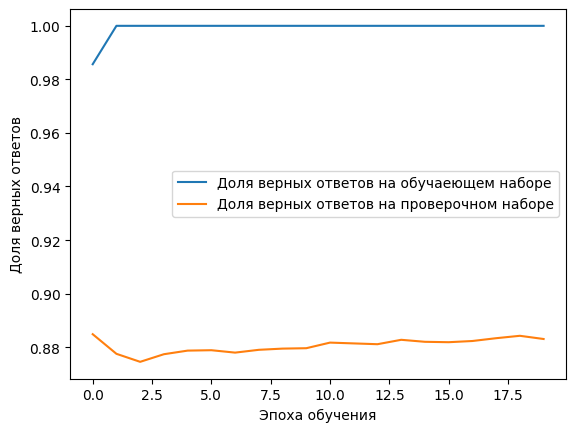

In [16]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model01.fit(xTrain01,
                     yTrain,
                     epochs=20,
                     batch_size=128,
                     validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'],
        label='Доля верных ответов на обучаеющем наборе')
plt.plot(history.history['val_accuracy'],
        label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [17]:
def createTestMultiClasses(wordIndexes, xLen, step, max_windows=400):
    nClasses = len(wordIndexes)

    xTest6Classes01 = []
    xTest6Classes = []

    for wI in wordIndexes:
        sample = getSetFronIndexes(wI, xLen, step)

        sample = sample[:max_windows]

        xTest6Classes.append(sample)
        xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))

    xTest6Classes01 = np.array(xTest6Classes01)
    xTest6Classes = np.array(xTest6Classes)

    return xTest6Classes01, xTest6Classes


In [18]:
def recognizeMultiClass(model, xTest, modelName):
    print('Model:', modelName)
    print()
    totalSumRec = 0

    for i in range(nClasses):
        currPred = model.predict(xTest[i])
        currOut = np.argmax(currPred, axis=1)

        evVal = []
        for j in range(nClasses):
            evVal.append(len(currOut[currOut==j])/len(xTest[i]))
        totalSumRec += len(currOut[currOut==i])
        recognizedClass = np.argmax(evVal)

        isRecoqnized = 'Это не правильный ответ'
        if recognizedClass == i:
            isRecoqnized = 'Это правильный ответ'
        str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
        print(str1, ' ' * (55 - len(str1)), isRecoqnized, sep='')
    print ()
    sumCount = 0
    for i in range(nClasses):
        sumCount += len(xTest[i])
    print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')
    print ()
    return totalSumRec/sumCount


In [19]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step)

In [20]:
pred = recognizeMultiClass(model01, xTest6Classes01, 'Тесты 01 + Dense')

Model: Тесты 01 + Dense

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Класс: O.Henry    91% сеть отнесла к классу O.Henry    Это правильный ответ
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Класс: Strugatsky 99% сеть отнесла к классу Strugatsky Это правильный ответ
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Класс: Bulgakov   51% сеть отнесла к классу Bulgakov   Это правильный ответ
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Класс: Clifford   76% сеть отнесла к классу Clifford   Это правильный ответ
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Класс: Max_Frei   100% сеть отнесла к классу Max_Frei  Это правильный ответ
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Класс: Bradbury   98% сеть отнесла к классу Bradbury   Это правильный ответ

Средний процент распознавания 86%



## Embedding + Dense 

In [21]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 20))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='softmax'))

modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.5100 - loss: 1.8297 - val_accuracy: 0.2929 - val_loss: 1.6022
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.4393 - val_loss: 1.2472
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss: 4.3987e-04 - val_accuracy: 0.7863 - val_loss: 0.7155
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss: 3.6785e-04 - val_accuracy: 0.8651 - val_loss: 0.4202
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss: 2.6854e-04 - val_accuracy: 0.8688 - val_loss: 0.3928
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss: 4.6028e-04 - val_accuracy: 0.7686 - val_loss: 0.6274
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9984 - loss: 0.0092 - val_accuracy: 0.9005 - val_loss: 0.3075
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss:

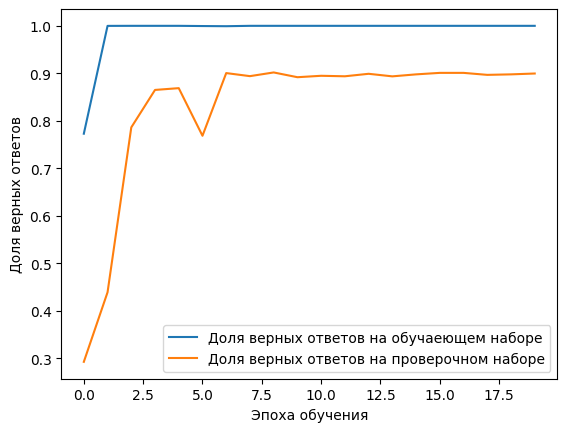

In [22]:
history = modelE.fit(xTrain01,
                     yTrain,
                     epochs=20,
                     batch_size=128,
                     validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'],
        label='Доля верных ответов на обучаеющем наборе')
plt.plot(history.history['val_accuracy'],
        label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()